# 3. Análisis de tópicos con LDA (Latent Dirichlet Allocation)

## 3.1 Motivación

El __análisis de tópicos__ permite descubrir, a partir de los propios textos, el conjunto de tópicos que estos abordan. Se trata de un análisis automatizado, que podría ser difícil de llevar a cabo manualmente, debido a la cantidad de textos.

Uno de los algoritmos más comunes para analizar tópicos es el algoritmo _Latent Dirichlet Allocation (LDA)_ (Artículo "Latent Dirichlet Allocation" : https://drive.google.com/file/d/1BobImO3192hifZPLXowd14gryVAUzBPW/view)

__¿Qué hace LDA?__

Dado un número de tópicos definido por el analista, el modelo permite asociar una distribución de tópicos $\theta_d$ a cada texto $d$ y al mismo tiempo, la distribución de palabras $\beta_t$ en cada tópico $t$.

<img src="img/f1.jpg"/>

<img src="img/f2.jpg"/>

## 3.2 ¿Cómo hacer un análisis de tópicos en Python?

En este tutorial, tomaremos un dataset de noticias de prensa en español del mes de febrero 2021 y utilizaremos LDA para descubrir cuáles son los tópicos de las noticias.

### 3.2.1 Cargar el dataset de noticias

In [1]:
import pandas

# leer el archivo CSV
archivo = './data/PuertoMontt_chile_2021-07-01_2021-12-31_POSITIVOS_BETO.csv'
corpus = pandas.read_csv(archivo)

In [2]:
corpus.head(5)

,id_news,title,date,title_label,title_score
0,47390948.0,De los artistas José Reyes y Gastón Ampuero: H...,2021-11-05,POS,0.833805
1,21445999.0,Dispar suerte corrió la Rama Femenina de Básqu...,2021-09-30,POS,0.504262
2,21382310.0,Embajador Jostein Leiro destacó relevancia de ...,2021-11-29,POS,0.816313
3,22333018.0,Bajo modalidad híbrida se hará la quinta Feria...,2021-10-11,POS,0.994042
4,21445870.0,CDSC Puerto Varas se coronó campeón en todas l...,2021-10-13,POS,0.609750


- Son 2.931 noticias en total.

In [3]:
len(corpus)

263

- Creamos una lista de noticias a partir del corpus

In [4]:
noticias = corpus.title.values.tolist()

### 3.2.2  Instalación de librerias

- Instalamos en nuestra máquina la libreria "pyLDAvis" que permite visualizar los resultados del análisis de tópicos 

Note bene: los comandos "pip install .." solo se hacen una vez para descargar las librerias en su computador.

In [6]:
#!pip install pyLDAvis

- Utilizaremos spacy para procesar textos en español (no es útil instalar la libreria con "pip instal..." ya que ya lo hicimos en notebook anterior)

In [5]:
import spacy
from spacy.matcher import PhraseMatcher, Matcher

nlp = spacy.load("es_core_news_md")

In [6]:

matcher = Matcher(nlp.vocab)

- Utilizaremos Gensim (para el análisis de tópicos) y pyLDAvis (para visualizar los tópicos)

In [7]:
#!pip install gensim

In [7]:
import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\tamib\miniconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


### 3.2.3 Preprocesamiento de las noticias

Procesaremos todas las noticias para representarlas como una lista de:
- sustantivos (NOUN)
- y conceptos claves (NOUN-de-NOUN) y (NOUN-ADJ)
- entidades (PER) y (ORG)

- Agregamos patrones para buscar conceptos claves

In [8]:
pattern_1 = [{"POS": "NOUN"},{"LOWER": "de"}, {"POS": "NOUN"}]
matcher.add("NOUN-de-NOUN", [pattern_1])

pattern_2 = [{"POS": "NOUN"}, {"POS": "ADJ"}]
matcher.add("NOUN-ADJ", [pattern_2])

- Definemos una función para preprocesar una noticia y transformarla en una lista de "palabras" relevantes.

In [9]:
def text_to_list(noticia):
    list_of_words = []
    
    try:
        doc = nlp(noticia)

        for token in doc:
            if (token.pos_=="NOUN"):
                list_of_words.append(token.text)

        for ent in doc.ents:
            if (ent.label_ == "PER" and " " in ent.text):
                list_of_words.append(ent.text)

        matches = matcher(doc)

        for match_id, start, end in matches:
            span = doc[start:end]  # The matched span
            list_of_words.append(span.text)
    
    except Exception as e: 
        print(noticia)
        print(e)
    
    return list_of_words

In [10]:
noticias[0]

'De los artistas José Reyes y Gastón Ampuero: Hoy se inaugura la muestra “Cofradía” en Galería Machacoya'

In [11]:
text_to_list(noticias[0])

['artistas', 'muestra', 'José Reyes', 'Gastón Ampuero']

- Transformamos todas las noticias de nuestro corpus "noticias" aplicando la función "text_to_list". De cierta manera, simplificará el texto guardando solamente las palabras y conceptos importantes.

In [12]:
noticias_procesadas = []

for index, noticia in enumerate(noticias):
    print(index)
    noticia_procesada = text_to_list(noticia)
    noticias_procesadas.append(noticia_procesada)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262


- Veamos cómo se transformó una cierta noticia. La variable "N" representa el rango de la noticia en nuestro corpus.

In [30]:
N=4

In [31]:
print(noticias[N])

CDSC Puerto Varas se coronó campeón en todas las series de la Liga Cecinas Llanquihue de Básquetbol


- Se simplificó en:

In [32]:
print(noticias_procesadas[5])

['relevancia', 'vínculos', 'Jostein Leiro']


### 3.2.4 Preparar los datos de entrada de LDA

los datos de entrada de LDA son: 
- un diccionario (variable 'id2word')
- nuestro dataset preprocesado ('noticias_procesadas')

In [33]:
# Create Dictionary
id2word = corpora.Dictionary(noticias_procesadas)
id2word

- Se asigna una ID a cada palabra (o concepto) del vocabulario. Por ejemplo con el ID=25 corresponde a la palabra:

In [34]:
id2word[179]

'balance'

In [35]:
texts = noticias_procesadas

- Ahora una noticia se vuelve imposible de leer para un humano. Miremos por ejemplo la noticia N.

In [36]:
dataset = [id2word.doc2bow(noticia_procesada) for noticia_procesada in noticias_procesadas]

# View
print(dataset[:N])

[[(0, 1), (1, 1), (2, 1), (3, 1)], [(4, 1), (5, 1), (6, 1), (7, 1)], [(8, 1), (9, 1)], [(10, 1), (11, 1)]]


### 3.3. Entrenamiento del modelo de tópico con LDA

- Entrenaremos un primer modelo de tópicos buscando un modelo con 5 tópicos. 

In [38]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=dataset,
                                           id2word=id2word,
                                           num_topics=N, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

- Guardaremos el modelo en el disco duro

In [39]:
lda_model.save('./output/lda_model_positivos')

### 3.4. Visualizar los tópicos encontrados

- Se puede imprimir los tópicos con sus principales palabras principales...

In [40]:
from pprint import pprint

pprint(lda_model.print_topics(num_words=100))

[(0,
  '0.028*"país" + 0.017*"región" + 0.012*"personas" + 0.010*"similitudes" + '
  '0.010*"diferencias" + 0.009*"concurso" + 0.009*"venta" + 0.007*"comunidad" '
  '+ 0.007*"equilibrio" + 0.007*"estrategias" + 0.007*"equilibrio laboral" + '
  '0.007*"convivencia exitosa" + 0.007*"convivencia" + 0.007*"busca" + '
  '0.007*"obras" + 0.007*"seguridad" + 0.007*"serie" + 0.007*"propuesta" + '
  '0.006*"entradas" + 0.006*"ciclismo" + 0.006*"hospitales" + '
  '0.006*"Deportistas" + 0.006*"torneo" + 0.005*"locales" + '
  '0.005*"Emprendedores" + 0.005*"Emprendedores porteños" + 0.005*"general" + '
  '0.005*"precedente" + 0.005*"contenido" + 0.005*"propuesta estética" + '
  '0.005*"televisión" + 0.005*"televisión abierta" + 0.005*"campeón" + '
  '0.005*"líderes" + 0.005*"domingo" + 0.005*"beneficios" + 0.005*"llegada" + '
  '0.005*"tecnología" + 0.005*"mar" + 0.005*"plata" + 0.005*"Familias" + '
  '0.005*"Familias de campamento" + 0.005*"salubridad" + 0.005*"campamento" + '
  '0.005*"líderes a

- ... o se puede visualizar mejor con la libreria pyLDAvis

Nota bene: el número que identifica los topicos puede cambiar... 

In [41]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, dataset, id2word)
vis

c:\Users\tamib\miniconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.071223  0.034121       1        1  33.443170
1     -0.178467 -0.021434       2        1  25.261496
3      0.077942 -0.120964       3        1  22.190402
2      0.029302  0.108277       4        1  19.104933, topic_info=                    Term      Freq     Total Category  logprob  loglift
470              columna  9.000000  9.000000  Default  30.0000  30.0000
472              opinión  9.000000  9.000000  Default  29.0000  29.0000
471   columna de opinión  9.000000  9.000000  Default  28.0000  28.0000
399                 país  8.000000  8.000000  Default  27.0000  27.0000
198             millones  5.000000  5.000000  Default  26.0000  26.0000
..                   ...       ...       ...      ...      ...      ...
521                largo  1.130548  1.579627   Topic4  -4.9848   1.3207
537              soporte  1.130546  1.579626   Topic4  -4.9848   1.3207
538  soporte tecnológico  1.130546  1.579626   Topic4  -4.9848   1.3207
77                  fase  1.767663  2.830754   Topic4  -4.5378   1.1843
515        Gastronómicos  1.130547  2.543784   Topic4  -4.9848   0.8443

[163 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
196       3  0.811068              $
123       2  0.539617           2022
33        1  0.976222    Deportistas
92        2  0.614106   Diego Rivera
493       1  0.682379  Emprendedores
...     ...       ...            ...
235       1  0.960083          venta
156       4  0.716263           vida
553       4  0.775884     visitantes
577       4  0.633060     voluntades
75        4  0.600547           zona

[140 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

### 3.5. Calcular las metricas de Perplejidad (_Model Perplexity_) y Coherencia (_Coherence Score_)

La perplejidad del modelo y la coherencia del tema proporcionan metricas estadisticas para evaluar que tan revante es un modelo para describir el dataset.

In [24]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(dataset))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=noticias_procesadas, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.070942444642844

Coherence Score:  0.5477618113849193


### 3.6. ¿Cómo encontrar cuál es el mejor número de tópicos para describir el dataset?

- Queremos encontrar el modelo que optimiza la métrica de coherencia (o minimiza la métrica de perplejidad). Probaremos con distintos valores de número de tópicos.

In [25]:
### NO CAMBIAR ESTA CELDA###

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        
        model = gensim.models.ldamodel.LdaModel(corpus=dataset,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

- Entrenaremos modelos desde 2 tópicos hasta 15 tópicos con un salto de 2 --> 2, 4, 6, 8, 10, 12, 14

Nota bene: Se puede demorar varios minutos (o incluso varias horas según el tamaño del dataset)

In [26]:
start=2
limit=15
step=2

In [27]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=dataset, texts=noticias_procesadas, start=start, limit=limit, step=step)

2
4
6
8
10
12
14


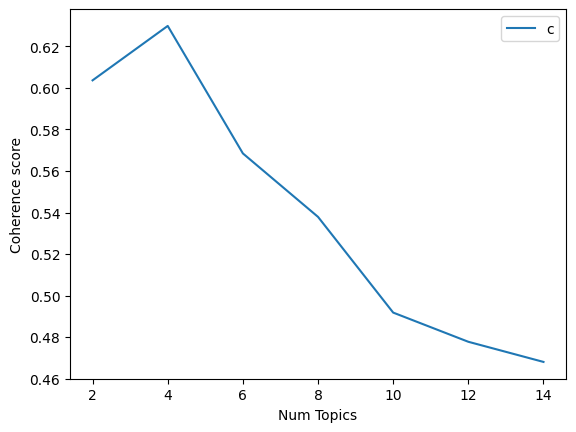

In [28]:

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

- ¿Cuál modelo conservar? Miraremos la métrica de coherencia...

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6037
Num Topics = 4  has Coherence Value of 0.6299
Num Topics = 6  has Coherence Value of 0.5685
Num Topics = 8  has Coherence Value of 0.5379
Num Topics = 10  has Coherence Value of 0.4918
Num Topics = 12  has Coherence Value of 0.4777
Num Topics = 14  has Coherence Value of 0.468


In [41]:
# Select the model and print the topics
optimal_model = model_list[4]

- Guardaremos el mejor modelo en un archivo para poder reutilizarlo despues sin volver a entrenar...

In [42]:
archivo='./output/optimal_model_catrillanca_10'

In [43]:
optimal_model.save(archivo)

- En cualquier momento, se puede volver a cargar el model desde el archivo, sin volver a entrenar el modelo...

In [44]:
from gensim.models import LdaModel

optimal_model = LdaModel.load(archivo, mmap='r')

- Visualizemos el modelo de tópicos

In [45]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, dataset, id2word)
vis

/home/mvernier/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.340391  0.068151       1        1  60.570616
8     -0.305393 -0.010848       2        1  16.492448
1     -0.277704  0.043393       3        1  15.805666
5      0.032353 -0.401829       4        1   3.531473
4      0.119032  0.043869       5        1   1.458445
2      0.147217  0.056715       6        1   1.201279
9      0.159813  0.054307       7        1   0.455221
0      0.158213  0.051689       8        1   0.380908
7      0.154028  0.047647       9        1   0.090276
3      0.152832  0.046906      10        1   0.013666, topic_info=                                Term         Freq        Total Category  \
3153                               }  1959.000000  1959.000000  Default   
3152                               {   722.000000   722.000000  Default   
92                                 “  2971.000000  2971.000000  Default   
10                              años  2671.000000  2671.000000  Default   
11                              caso  2133.000000  2133.000000  Default   
...                              ...          ...          ...      ...   
32687             temas prioritarios     0.001287     0.400486  Topic10   
16535              triunfo electoral     0.001303     0.419622  Topic10   
16427                jefes comunales     0.001303     0.505890  Topic10   
32670  convencionales constituyentes     0.001287     0.409085  Topic10   
32673           desafíos electorales     0.001287     0.404562  Topic10   

       logprob  loglift  
3153   30.0000  30.0000  
3152   29.0000  29.0000  
92     28.0000  28.0000  
10     27.0000  27.0000  
11     26.0000  26.0000  
...        ...      ...  
32687 -10.5606   3.1577  
16535 -10.5484   3.1232  
16427 -10.5484   2.9362  
32670 -10.5606   3.1364  
32673 -10.5606   3.1475  

[454 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
771       1  0.110314        #
771       2  0.888756        #
4043      6  1.001907       //
4044      6  1.001907  24horas
4047      6  0.994181        =
...     ...       ...      ...
92        2  0.039715        “
92        3  0.470858        “
216       1  0.489236        ”
216       2  0.051043        ”
216       3  0.459821        ”

[445 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 2, 6, 5, 3, 10, 1, 8, 4])

### 8. ¿Cuál es el tópico principal de cada documento?

- Podemos analizar cuál es el tópico principal de cada documento

In [49]:
def format_topics_documents(ldamodel=None, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_documents(ldamodel=optimal_model, corpus=dataset, texts=noticias)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.5353,"}, años, fiscal, caso, casos, investigación, a...",El Instituto Nacional de Derechos Humanos (IND...
1,1,6.0,0.4799,"gobierno, ministro, parte, año, país, “, perso...",Hasta el Palacio de la Moneda llegó Marcelo Ca...
2,2,1.0,0.5068,"“, ”, policía, general, lugar, carabineros, mo...",SANTIAGO.- A casi cuatro meses de la muerte de...
3,3,6.0,0.5163,"gobierno, ministro, parte, año, país, “, perso...","Hace unos días Marcelo Catrillanca, padre de C..."
4,4,6.0,0.7267,"gobierno, ministro, parte, año, país, “, perso...","Durante la mañana de este jueves, un grupo de ..."
5,5,6.0,0.5430,"gobierno, ministro, parte, año, país, “, perso...","Marcelo Catrillanca, padre del comunero mapuch..."
6,6,6.0,0.4237,"gobierno, ministro, parte, año, país, “, perso...","Durante la tarde de este lunes, fue detenido M..."
7,7,1.0,0.2663,"“, ”, policía, general, lugar, carabineros, mo...","Este lunes fue detenido Marcelo Catrillanca, p..."
8,8,6.0,0.6756,"gobierno, ministro, parte, año, país, “, perso...",El padre de Camilo Catrillanca realizó un llam...
9,9,1.0,0.4987,"“, ”, policía, general, lugar, carabineros, mo...",Un comunero mapuche murió tras ser herido a ba...


- La variable "df_dominant_topic" contiene una columna "Dominant_topic" que indica el tópico principal en cada documento y cuál su porcentaje (variable "Topic_Perc_contrib")

- Añadiremos la columna "media_outlet" para saber de qué medio viene cada noticia

In [50]:
media_outlet = corpus.filter(['media_outlet'], axis=1)
df_dominant_topic=df_dominant_topic.join(media_outlet)
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,media_outlet
0,0,8.0,0.5353,"}, años, fiscal, caso, casos, investigación, a...",El Instituto Nacional de Derechos Humanos (IND...,horas24
1,1,6.0,0.4799,"gobierno, ministro, parte, año, país, “, perso...",Hasta el Palacio de la Moneda llegó Marcelo Ca...,ahoranoticiasmega
2,2,1.0,0.5068,"“, ”, policía, general, lugar, carabineros, mo...",SANTIAGO.- A casi cuatro meses de la muerte de...,emol
3,3,6.0,0.5163,"gobierno, ministro, parte, año, país, “, perso...","Hace unos días Marcelo Catrillanca, padre de C...",ahoranoticiasmega
4,4,6.0,0.7267,"gobierno, ministro, parte, año, país, “, perso...","Durante la mañana de este jueves, un grupo de ...",ahoranoticiasmega
...,...,...,...,...,...,...
2926,2926,6.0,0.5637,"gobierno, ministro, parte, año, país, “, perso...","Acusados por incendios, porte y lanzamiento de...",elciudadano
2927,2927,6.0,0.7508,"gobierno, ministro, parte, año, país, “, perso...",Mauricio Hernández Norambuena (62) pasó 17 año...,elciudadano
2928,2928,6.0,0.7508,"gobierno, ministro, parte, año, país, “, perso...",Mauricio Hernández Norambuena (62) pasó 17 año...,elciudadano
2929,2929,6.0,0.7279,"gobierno, ministro, parte, año, país, “, perso...",ARTE Delight lab: Artistas y activistas lumíni...,latercera


- Podemos contar cuántos documentos son por tópicos principales:

In [51]:
from pandasql import sqldf 

In [52]:
result = sqldf("SELECT Dominant_Topic, count(*) as nb_noticias FROM df_dominant_topic GROUP BY Dominant_Topic ORDER BY count(*) DESC")
result

,Dominant_Topic,nb_noticias
0,6.0,2129
1,8.0,421
2,1.0,345
3,2.0,20
4,5.0,15
5,7.0,1


- ¿Cuál es la noticia más representativa de cada tópcio?

- Tópico 1

In [53]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT * FROM df_dominant_topic WHERE dominant_topic=1.0 ORDER BY Topic_Perc_Contrib DESC LIMIT 1")
result

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,media_outlet
0,95,1.0,0.7821,"“, ”, policía, general, lugar, carabineros, momento, operativo, personas, información","Al momento del baleo que finalmente le provocó la muerte, Camilo Catrillanca iba acompañado en su tractor por un adolescente de 15 años que posteriormente fue detenido por Carabineros que participaron en el operativo. El menor, de iniciales M.A.P.C., entregó su testimonio al Instituto Nacional de Derechos Humanos (INDH), donde reveló pormenores del cuestionado procedimiento. En detalles dados a conocer por Cooperativa, aseguró que los carabineros a cargo del operativo cambiaron sus cámaras tras disparar contra ellos. : General Soto confirma que carabineros involucrados en muerte de Camilo Catrillanca no llevaban cámaras para grabarLeer más ""Él iba con Camilo Catrillanca en el tractor y de repente se encuentran con Carabineros que empiezan a disparar primero balines de goma y después balas. En ese minuto Camilo Catrillanca le dice (al menor) 'agáchate que están disparando', se agachan y él ve a Camilo botando un líquido por la nariz y se da cuenta que le dispararon"", señaló Consuelo...",horas24


- Tópico 2

In [54]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT * FROM df_dominant_topic WHERE dominant_topic=2.0 ORDER BY Topic_Perc_Contrib DESC LIMIT 1")
result

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,media_outlet
0,2804,2.0,0.5089,"{, function, =, block, duracion, relative, volumen, defecto, //, 24horas","El Presidente de la República, Sebastián Piñera, enfrentó la noche de este miércoles al panel del programa ""Llegó tu Hora"" de TVN, instancia en la cual abordó los principales temas de la contingencia como la crisis que sacude a Carabineros y a las Fuerzas Armadas, además de la actual situación de TVN, entre otras temáticas. Sobre los reiterados cuestionamientos al General director de la policía uniformada, Hermes Soto, el Mandatario descartó pedirle la renuncia en lo pronto y aseguró que le exigió que entregara toda la información correspondiente al homicidio de Camilo Catrillanca: ""Me reuní con el general Hermes Soto y con los generales inspectores. Les pedí que entregaran toda la información que tenían a la fiscalía, porque ese es su deber. También pedí que la eficacia operacional de Carabineros mejorara sustancialmente"". .storyVideoBody, controlBody2916357 {display:block; position:relative; margin:1em 0; padding:0; clear:both; overflow:hidden;width: 650px;}Presidente Piñera por ...",horas24


- Tópico 5

In [55]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT * FROM df_dominant_topic WHERE dominant_topic=5.0 ORDER BY Topic_Perc_Contrib DESC LIMIT 5")
result

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,media_outlet
0,2199,5.0,0.5541,"crisis, millones, confianza, ministros, Chile Vamos, veces, oficialismo, partido, clase, pesos","TEMUCO. – Después de la sorpresiva derrota ante Costa Rica en Rancagua, la selección chilena necesitaba encontrarse con los abrazos para cerrar de buena manera el ""traumático y tortuoso""período del recambio, según las propias palabras del técnico Reinaldo Rueda. Noticia relacionada La ""Roja"" de Rueda no da espectáculo, pero mejora y golea a Honduras gracias a tres penales Y lo hizo con creces venciendo por 4-1 a Honduras en Temuco . Una victoria contundente y que denotó una leve mejoría en el equipo. Pero sin lugar a duda el duelo disputado en el estadio Germán Becker no será recordado por lo futbolístico, sino que por todo lo que generó antes y durante su desarrollo. El minuto de silencio que no fue y el apoyo de los jugadores Desde que la ""Roja"" pisó suelo temuquense el domingo se hizo sentir la t ensión por el conflicto mapuche que se vive en la zona. Pese a que la ANFP deslizó la opción de realizar un minuto de silencio por la muerte del comunero Camilo Catrillanca , fina...",emol
1,2200,5.0,0.5541,"crisis, millones, confianza, ministros, Chile Vamos, veces, oficialismo, partido, clase, pesos","TEMUCO. – Después de la sorpresiva derrota ante Costa Rica en Rancagua, la selección chilena necesitaba encontrarse con los abrazos para cerrar de buena manera el ""traumático y tortuoso""período del recambio, según las propias palabras del técnico Reinaldo Rueda. Noticia relacionada La ""Roja"" de Rueda no da espectáculo, pero mejora y golea a Honduras gracias a tres penales Y lo hizo con creces venciendo por 4-1 a Honduras en Temuco . Una victoria contundente y que denotó una leve mejoría en el equipo. Pero sin lugar a duda el duelo disputado en el estadio Germán Becker no será recordado por lo futbolístico, sino que por todo lo que generó antes y durante su desarrollo. El minuto de silencio que no fue y el apoyo de los jugadores Desde que la ""Roja"" pisó suelo temuquense el domingo se hizo sentir la t ensión por el conflicto mapuche que se vive en la zona. Pese a que la ANFP deslizó la opción de realizar un minuto de silencio por la muerte del comunero Camilo Catrillanca , fina...",emol
2,1944,5.0,0.5401,"crisis, millones, confianza, ministros, Chile Vamos, veces, oficialismo, partido, clase, pesos","Pese a que Colo Colo consiguió abrochar el objetivo mínimo que tenía en el Campeonato Nacional, tras clasificar a Copa Sudamericana 2019, lo cierto es que el andamiaje del elenco albo bajo el mando de Héctor Tapia no ha sido el esperado, y aquello lo sabe de sobra Claudio Borghi, el único técnico capaz de conseguir un tetracampeonato en el fútbol chileno al frente de los albos. ""Tapia tenía que clasificar a un torneo internacional sabiendo que no se iba a quedar; los jugadores daban declaraciones con contratos no firmados, buscando renovación. Incluso los jugadores dando una despedida al técnico? es difícil. Se creó un ambiente muy complicado de manejar"", aseguró Borghi en DirecTV. ""Colo Colo es un enfermo terminal (...) Es como cuando te dicen que te quedan seis meses de vida, después cuatro? Y los doctores empiezan a opinar de tu salud. Es una muerte anunciada"", agregó el DT. MIRA TAMBIÉN: ANFP nuevamente negó minuto de silencio por Camilo Catrillanca solicitado por Colo Colo Fin...",ahoranoticiasmega
3,1572,5.0,0.5249,"crisis, millones, confianza, ministros, Chile Vamos, veces, oficialismo, partido, clase, pesos","La U de Conce derrotó como visita por 2-0 a Colo Colo, en el duelo que cerró la participación de ambos conjuntos en el Torneo Nacional. Con este logro el cuadro amarillo se metió en la fase de grupos de Copa Libertadores 2019, ya que terminó en el segundo lugar del certamen criollo. MIRA TAMBIÉN: Colo Colo y U de Conce realizan minuto de silencio no autorizado por la ANFP en honor a Camilo Catrillanca El elenco de Francisco

- Tópico 6

In [56]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT * FROM df_dominant_topic WHERE dominant_topic=6.0 ORDER BY Topic_Perc_Contrib DESC LIMIT 3")
result

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,media_outlet
0,414,6.0,0.9549,"gobierno, ministro, parte, año, país, “, personas, años, oposición, ”","PUNTA ARENAS.- Luego de visitar Puerto Williams, el Presidente Sebastián Piñera arribó esta noche en Santiago, cerrando así una jornada que en la capital estuvo marcada por las críticas de la oposición al rol que ha tenido el ministro del Interior, Andrés Chadwick , tras la muerte del comunero mapuche Camilo Catrillanca. La presión de la oposición exigiendo la renuncia del ministro y la evaluación de una posible acusación constitucional en su contra ha crecido, luego de que el renunciado general de Carabineros Mauro Victtoriano declarara supuestamente que él le informó a Chadwick que el comunero no estaba armado en el operativo en que murió. Noticias relacionadas Chadwick ante críticas de la oposición por caso Catrillanca: ""No he pensado en renunciar"" El informe de Carabineros que recibió el ministro Chadwick horas después de la muerte de Catrillanca Versión ante la cual, Chadwick reconoció ayer que ""lamentablemente había una muy mala comunicación e interferencia, por lo ta...",emol
1,1276,6.0,0.9520,"gobierno, ministro, parte, año, país, “, personas, años, oposición, ”","¿Cómo evalúa la reacción de las autoridades por la muerte de Camilo Catrillanca? Demasiado lenta; sus primeras declaraciones fueron actuando con el racismo y la forma que siempre han tenido ante cualquier hecho que se genere con mapuches, como acciones violentistas y terroristas. Ellos no hacen la autocrítica respecto de las actuaciones que tuvieron. ¿Fue suficiente, en términos de responsabilidades políticas, la renuncia del intendente Luis Mayol? No es suficiente. El ministro del Interior es el que tiene que velar por la seguridad pública, es el que debió haber tenido información de primera fuente de parte de Carabineros, es quien articula y se coordina con los intendentes regionales. En él sigue habiendo una responsabilidad política. Era mucho más fácil cortar por el hilo más delgado, que era la salida del intendente. ¿Y debería entonces renunciar Chadwick? Mientras no se aclare lo sucedido seguirá existiendo este nivel de desconfianza. El ministro no renunciará, el Presidente t...",latercera
2,2779,6.0,0.9490,"gobierno, ministro, parte, año, país, “, personas, años, oposición, ”","El diputado Vlado Mirosevic, del Partido Liberal (PL), la colectividad más al centro en el Frente Amplio, cree fundamental poner condiciones para comenzar un diálogo programático en la centroizquierda. La principal: una autocrítica de la ex nueva Mayoría y ""dejar atrás el tono de arrogancia"" y de ""superioridad moral"" desde el Frente Amplio. Además, como miembro y expresidente de la Comisión de Relaciones Exteriores de la Cámara, analiza la relación de La Moneda con la oposición tras la polémica por el pacto migratorio. ¿La decisión del Presidente Sebastián Piñera de restarse del pacto migratorio cambia la relación de la oposición con el gobierno? Definitivamente lo cambia. El gobierno ha sido tremendamente irresponsable porque se está saliendo de la política de Estado que hemos tenido en los últimos 25 años. Lo que están haciendo justamente es utilizar la política exterior para efectos de política interna, con una motivación de legitimidad y posicionamiento. El Presidente ha defend...",latercera


- tópico 7

In [57]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT * FROM df_dominant_topic WHERE dominant_topic=7.0 ORDER BY Topic_Perc_Contrib DESC LIMIT 1")
result

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,media_outlet
0,1943,7.0,0.4661,"violencia policial, consigna, shared, licencia, post, orden de detención, this post, this, causa derivada, licencia médica","Salir a comer junto a tu perro nunca fue tan divertido como en Ushisuke, una cadena de restaurantes que se ubica en Tokyo y Yakohama, en Japón, donde los comensales pueden ir acompañados de sus caninos, sin ningún problema. En el particular restaurante no solo cocinan deliciosas carne para ti, sino también que también tienen disponible un menú exclusivo para tu perro. El lugar no ha escapado de la fiebre viral y usuarios aprovechan para compartir en las redes sociales imágenes y videos cuando visitan el lugar junto a sus peludos. View this post on InstagramA post shared by わたあめ (@wata201312) A post shared by わたあめ (@wata201312) MIRA TAMBIÉN: Paleontólogo chileno bautiza como ""Camilo Catrillanca"" a desaparecida especie de pez espada Las mascotas pueden sentarse a la mesa y ordenar, además el alimento para las criaturas parece ser ligeramente diferente de lo que comen: View this post on InstagramA post shared by もち&あずき (@mocci_azuki) A post shared by もち&あずき (@mocci_azuki) View this ...",ahoranoticiasmega


In [58]:
noticias[1943]

'Salir a comer junto a tu perro nunca fue tan divertido como en Ushisuke, una cadena de restaurantes que se ubica en Tokyo y Yakohama, en Japón, donde los comensales pueden ir acompañados de sus caninos, sin ningún problema. En el particular restaurante no solo cocinan deliciosas carne para ti, sino también que también tienen disponible un menú exclusivo para tu perro. El lugar no ha escapado de la fiebre viral y usuarios aprovechan para compartir en las redes sociales imágenes y videos cuando visitan el lugar junto a sus peludos. View this post on InstagramA post shared by わたあめ (@wata201312) A post shared by わたあめ (@wata201312) MIRA TAMBIÉN:\xa0Paleontólogo chileno bautiza como "Camilo Catrillanca" a desaparecida especie de pez espada Las mascotas pueden sentarse a la mesa y ordenar, además el alimento para las criaturas parece ser ligeramente diferente de lo que comen: View this post on InstagramA post shared by もち&あずき (@mocci_azuki) A post shared by もち&あずき (@mocci_azuki) View this 

- tópico 8

In [59]:
?

__¿Conclusiones?__

- El tópico de "violaciones/democracia/manifestaciones" nunca es el tópico central de la noticia que hablan de Catrillanca. Es un tópico al segundo plano.

- ...

__¿Cómo nombrar los tópicos?__

Del más frecuente al menos frecuente...

6 --> Consecuencias del caso Catrillanca para el gobierno y sus ministros

8 --> Consecuencias judiciales del caso Catrillanca

1 --> Relato del caso Catrillanca

2 --> Noticias que integran un medio con ruido HTML (video, redes sociales)

5 --> Crisis de confianza instituciones Carabiñeros y Fuerzas Armadas



¿Qué medios hablan de crisis de confianza?

In [60]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT media_outlet,dominant_topic, count(*) FROM df_dominant_topic GROUP BY media_outlet,dominant_topic ORDER BY media_outlet, count(*) DESC")
result

,media_outlet,Dominant_Topic,count(*)
0,ahoranoticiasmega,6.0,312
1,ahoranoticiasmega,8.0,85
2,ahoranoticiasmega,1.0,67
3,ahoranoticiasmega,5.0,4
4,ahoranoticiasmega,7.0,1
5,biobiochile,6.0,129
6,biobiochile,8.0,67
7,biobiochile,1.0,16
8,elciudadano,6.0,217
9,elciudadano,1.0,54


In [61]:
data = {'t0':[],'t1':[],'t2':[],'t3':[],'t4':[],'t5':[],'t6':[],'t7':[],'t8':[],'t9':[]}

df_by_media = pd.DataFrame(data)  
  
df_by_media

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9


In [62]:
 for i, row_list in enumerate(optimal_model[dataset]):
    
    t0=0
    t1=0
    t2=0
    t3=0
    t4=0
    t5=0
    t6=0
    t7=0
    t8=0
    t9=0
    
    for topic in row_list[0]:
        key=topic[0]
        value=topic[1]
        
        if key == 0:
            t0 = value
        if key == 1:
            t1 = value
        if key == 2:
            t2 = value
        if key == 3:
            t3 = value
        if key == 4:
            t4 = value
        if key == 5:
            t5 = value
        if key == 6:
            t6 = value
        if key == 7:
            t7 = value
        if key == 8:
            t8 = value
        if key == 9:
            t9 = value
            
    new_row = {'t0':t0,'t1':t1,'t2':t2,'t3':t3,'t4':t4,'t5':t5,'t6':t6,'t7':t7,'t8':t8,'t9':t9}
    df_by_media = df_by_media.append(new_row, ignore_index=True)

In [63]:
df_by_media=df_by_media.join(media_outlet)

In [64]:
df_by_media

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,media_outlet
0,0.000000,0.203575,0.000000,0.0,0.000000,0.000000,0.248972,0.0,0.535306,0.0,horas24
1,0.000000,0.203498,0.000000,0.0,0.131969,0.000000,0.479870,0.0,0.174592,0.0,ahoranoticiasmega
2,0.105276,0.506815,0.000000,0.0,0.000000,0.000000,0.282243,0.0,0.099489,0.0,emol
3,0.000000,0.275287,0.000000,0.0,0.000000,0.000000,0.516315,0.0,0.198152,0.0,ahoranoticiasmega
4,0.000000,0.152684,0.000000,0.0,0.000000,0.000000,0.726698,0.0,0.106639,0.0,ahoranoticiasmega
...,...,...,...,...,...,...,...,...,...,...,...
2926,0.000000,0.104064,0.000000,0.0,0.026790,0.017996,0.563653,0.0,0.283303,0.0,elciudadano
2927,0.000000,0.057192,0.000000,0.0,0.024322,0.051408,0.750773,0.0,0.105533,0.0,elciudadano
2928,0.000000,0.057192,0.000000,0.0,0.024322,0.051408,0.750773,0.0,0.105533,0.0,elciudadano
2929,0.000000,0.075108,0.000000,0.0,0.013845,0.120394,0.727900,0.0,0.047324,0.0,latercera


In [65]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT media_outlet,avg(t0),avg(t1),avg(t2),avg(t3),avg(t4),avg(t5),avg(t6),avg(t7),avg(t8),avg(t9) FROM df_by_media GROUP BY media_outlet ORDER BY media_outlet ASC")
result

,media_outlet,avg(t0),avg(t1),avg(t2),avg(t3),avg(t4),avg(t5),avg(t6),avg(t7),avg(t8),avg(t9)
0,ahoranoticiasmega,0.004850,0.201786,0.000709,0.000000,0.008691,0.033961,0.531414,0.003275,0.202596,0.003848
1,biobiochile,0.002920,0.148526,0.000120,0.000000,0.022523,0.026877,0.515667,0.003467,0.270828,0.001634
2,elciudadano,0.003501,0.220471,0.000071,0.000000,0.018336,0.018569,0.533781,0.000883,0.194584,0.002299
3,elmostrador,0.004377,0.152084,0.000000,0.000000,0.010987,0.020211,0.527711,0.001203,0.270267,0.003316
4,emol,0.002448,0.148822,0.000596,0.000081,0.007527,0.041342,0.626292,0.000370,0.163678,0.002296
5,horas24,0.002682,0.174490,0.049163,0.000032,0.007891,0.030844,0.527190,0.000205,0.195304,0.003847
6,latercera,0.001443,0.162285,0.000201,0.000138,0.008767,0.029788,0.650348,0.000383,0.136124,0.002974


In [66]:
import seaborn as sns
%matplotlib inline

<AxesSubplot:>

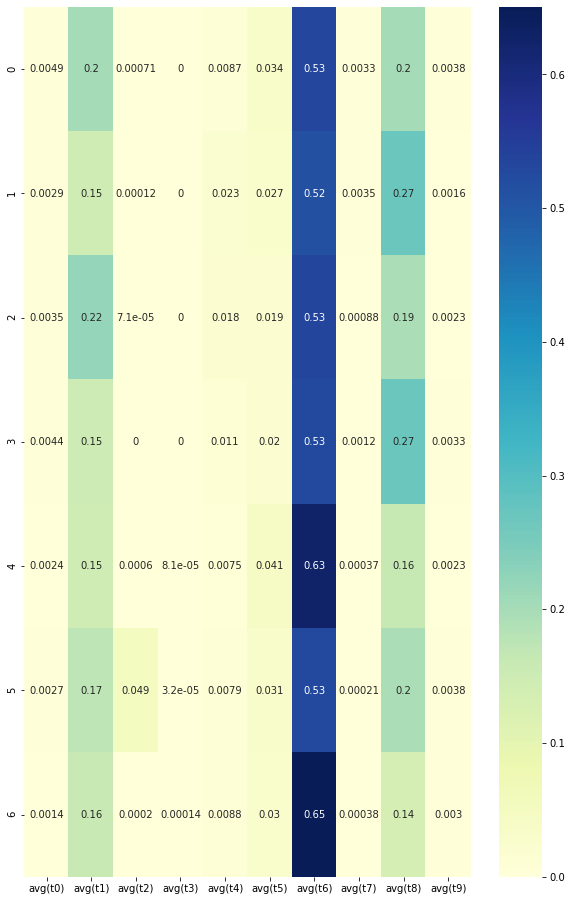

/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alterna

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 16))

result=result.drop(['media_outlet'], axis=1)
sns.heatmap(result, annot=True, cmap="YlGnBu")